Trước khi run pip, cài đặt các thư viện bằng câu lệnh sau
```
pip install pandas numpy matplotlib scikit-learn keras==3.3.3 tensorflow xgboost
```

In [1]:
# Nhập thư viện
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,SimpleRNN,Dense,Dense

from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
import MetaTrader5 as mt
from datetime import datetime

In [2]:
mt.initialize()

login = 84193298
password = "-8WyMrVz"
server = "MetaQuotes-Demo"

mt.login(login, password, server)

def get_data_FX(symbol, timeframe, rows):
    ohlc_data = pd.DataFrame(mt.copy_rates_from_pos(symbol, timeframe, 0, rows))
    ohlc_data['time'] = ohlc_data.apply(lambda x: datetime.fromtimestamp(x["time"]), axis=1)
    ohlc_data = ohlc_data.rename(columns={'time': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'real_volume': 'Volume'})
    ohlc_data.set_index("Date")
    return ohlc_data

df = get_data_FX('EURUSD', mt.TIMEFRAME_H1,2000)
df.head()

,Date,Open,High,Low,Close,tick_volume,spread,Volume
0,2024-03-26 11:00:00,1.08404,1.08442,1.08398,1.08425,1002,0,0
1,2024-03-26 12:00:00,1.08426,1.08441,1.08358,1.08369,682,0,0
2,2024-03-26 13:00:00,1.08369,1.08410,1.08364,1.08401,678,0,0
3,2024-03-26 14:00:00,1.08401,1.08481,1.08397,1.08471,871,0,0
4,2024-03-26 15:00:00,1.08471,1.08519,1.08463,1.08506,1051,0,0


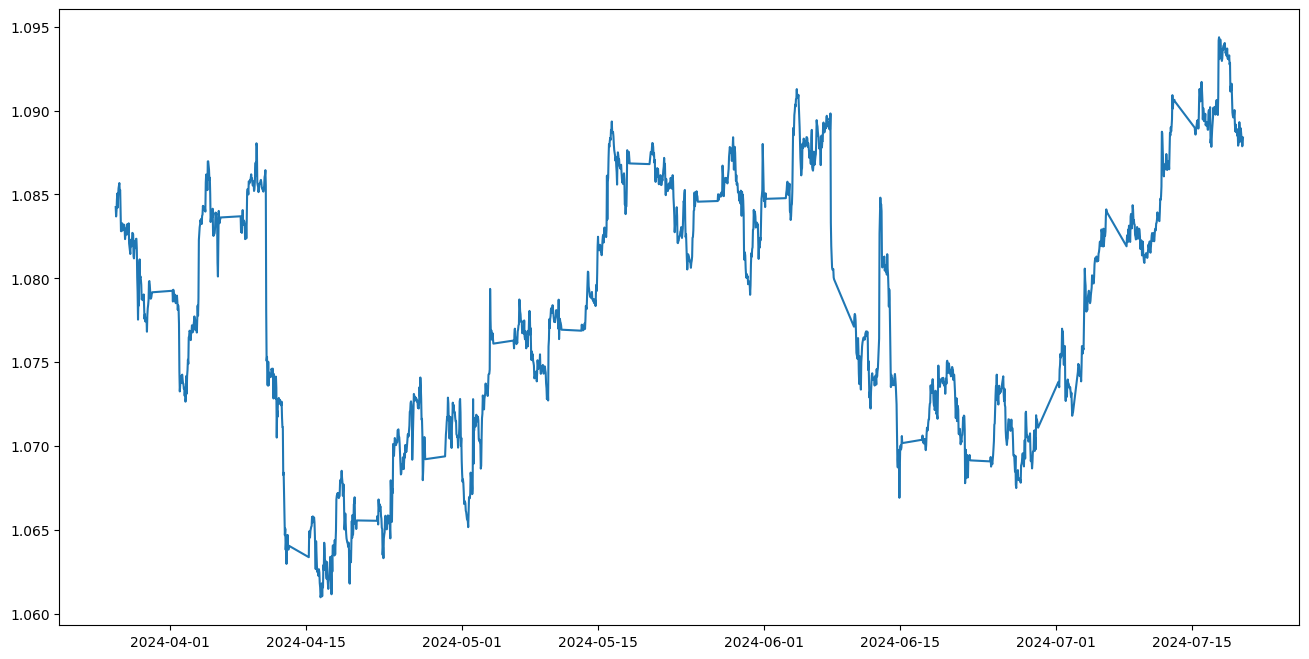

In [3]:
# Phân tích giá đóng cửa từ dataframe
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date'].values

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')
plt.show()

In [4]:
# Sắp xếp dữ liệu theo thứ tự ngày tăng dần và lấy ra 2 cột Date và Close

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset.loc[i, "Date"]=data['Date'].iloc[i]
    new_dataset.loc[i, "Close"]=data["Close"].iloc[i]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

print(new_dataset.head())

                       Close
Date                        
2024-03-26 11:00:00  1.08425
2024-03-26 12:00:00  1.08369
2024-03-26 13:00:00  1.08401
2024-03-26 14:00:00  1.08471
2024-03-26 15:00:00  1.08506


d:\Apps\Lib\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


In [5]:
# Chuẩn hóa dữ liệu
final_dataset=new_dataset.Close.values.reshape(-1,1)

train_data=final_dataset[0:1500,:]
valid_data=final_dataset[1500:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data_3D = x_train_data.reshape(x_train_data.shape[0], x_train_data.shape[1],1)

In [6]:
# Dựng và huấn luyện mô hình XGBoost
xgb_model=xgb.XGBRegressor()

xgb_model.fit(x_train_data,y_train_data)

# Lưu mô hình XGBoost
xgb_model.save_model("model/xgboost_close_model.json")

In [7]:
# Dựng và huấn luyện mô hình RNN
rnn_model=Sequential()
rnn_model.add(SimpleRNN(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
rnn_model.add(SimpleRNN(units=50))
rnn_model.add(Dense(1))

rnn_model.compile(loss='mean_squared_error',optimizer='adam')
rnn_model.fit(x_train_data_3D,y_train_data,epochs=1,batch_size=1,verbose=2)

# Lưu mô hình RNN
rnn_model.save("model/rnn_close_model.keras")

d:\Apps\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1440/1440 - 23s - 16ms/step - loss: 0.0040


In [8]:
# Dựng và huấn luyện mô hình LSTM
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data_3D,y_train_data,epochs=1,batch_size=1,verbose=2)

# Lưu mô hình LSTM
lstm_model.save("model/lstm_close_model.keras")

1440/1440 - 32s - 22ms/step - loss: 0.0057


In [9]:
# Lấy mẫu từ dữ liệu để đưa ra dự đoán giá cổ phiếu bằng các mô hình:
inputs_data=new_dataset.Close[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

prediction_xgb=xgb_model.predict(X_test).reshape(-1, 1)
prediction_xgb=scaler.inverse_transform(prediction_xgb)

prediction_rnn=rnn_model.predict(X_test)
prediction_rnn=scaler.inverse_transform(prediction_rnn)

prediction_lstm=lstm_model.predict(X_test)
prediction_lstm=scaler.inverse_transform(prediction_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


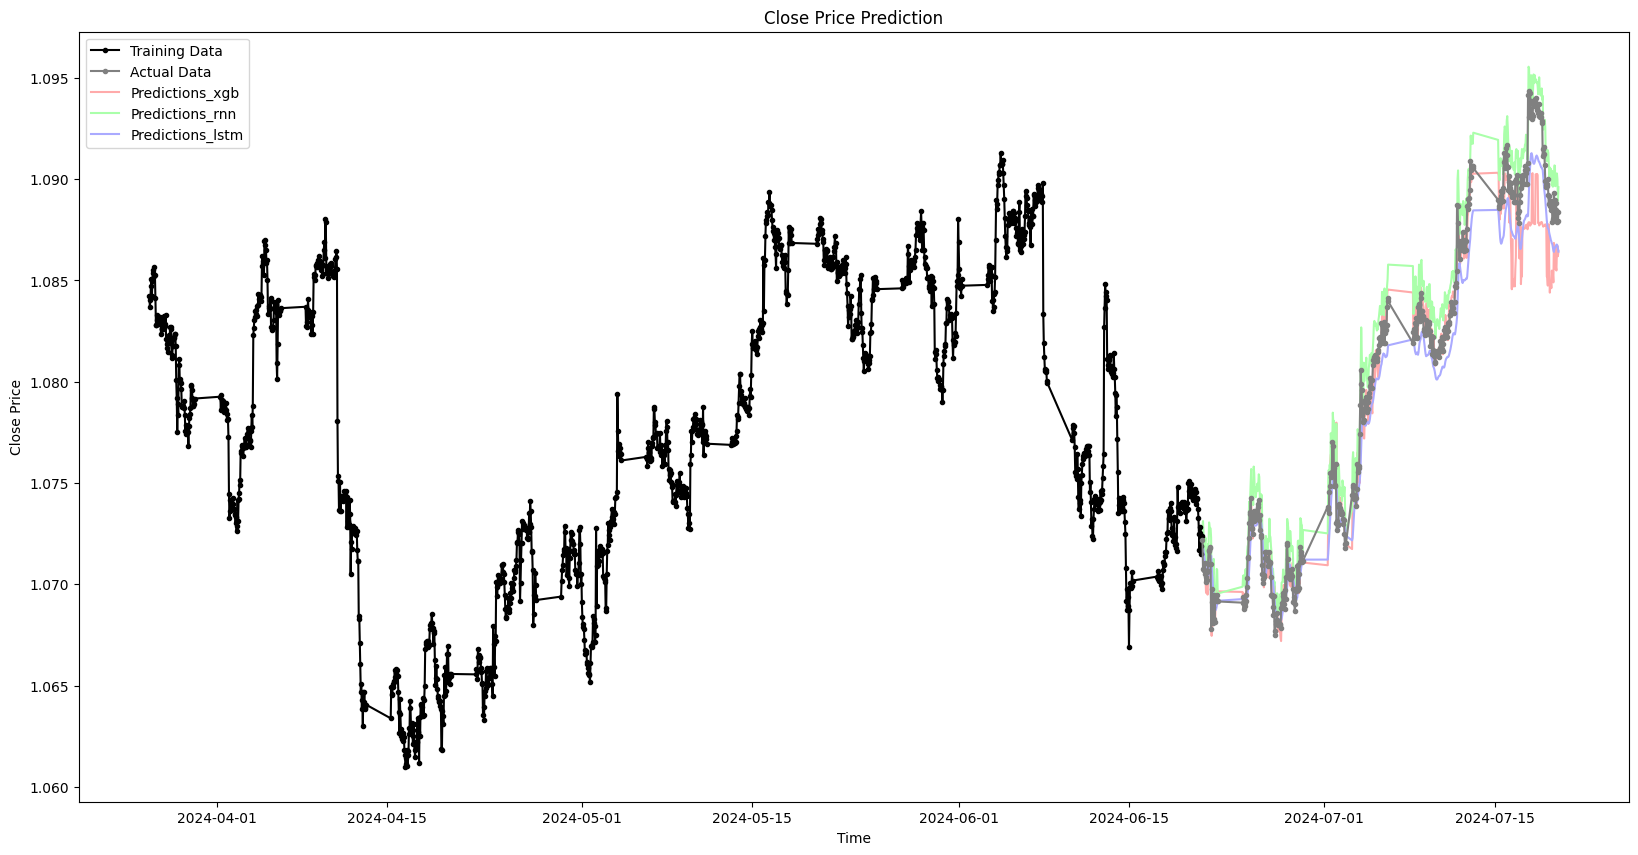

In [10]:
# Vẽ biểu đồ giá cổ phiếu dự đoán và thực tế
train_data=new_dataset[:1500]
valid_data=new_dataset[1500:].copy()
valid_data['Predictions_xgb']=prediction_xgb
valid_data['Predictions_rnn']=prediction_rnn
valid_data['Predictions_lstm']=prediction_lstm

plt.plot(train_data.Close, label='Training Data', color = 'black', marker = '.', zorder=10)
plt.plot(valid_data.Close, label='Actual Data', color = 'gray', marker = '.', zorder=10)
plt.plot(valid_data.Predictions_xgb, label='Predictions_xgb', color = '#FAA')
plt.plot(valid_data.Predictions_rnn, label='Predictions_rnn', color = '#AFA')
plt.plot(valid_data.Predictions_lstm, label='Predictions_lstm', color = '#AAF')
plt.title('Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()
plt.show()